In [1]:
#goal is to collect some demographic information using the patient class 

# libraries and dirrectories 

In [2]:
#libraries and dirrectory 
# import missingno as msno
import patientFunctions as ptFn
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit


## directory navigation

In [3]:
#location of original data
starting_directory = os.getcwd()

# machine_directory = 'C:/Users/mcremer' #the C and path to the project folder
machine_directory = 'C:/Users/maega' #when working from home machine
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '012 Processed Data/data-2024-06-05' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

new_dirrectory = path

os.chdir(new_dirrectory)

In [4]:
#updates to directory management
storage_directory = 'UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects' #Local, HPG, or dropbox
project_directory = 'Cardiac-Amyloidosis-Multiple-Myeloma' #project folder
project_lv2_directory = '014_Mistic2' #deeper part of project folder

path = os.path.join(machine_directory, storage_directory, 
                    project_directory, project_lv2_directory)

# parent_dir = path
outputDir = path

In [5]:
folderNameHeader = "PtDemographics_"
folderNameCommon = "2024-10-28_"
folderNameSuffix = "v1"

fileNameHeader_Known = "AL_KnownPts_"
fileNameHeader_Unknown = "AL_UnknownPts_"
fileNameHeader_Pos = "AL_PosPts_"
fileNameHeader_Neg = "AL_NegPts_"
fileNameHeader_all = "AllPts_"
fileNameCommon = "Demographics_"
fileNameSuffix = "2024-10-28_v1"

folder_data_out = ptFn.makeFolderPathForData(parent_dir=outputDir, folderName_header=folderNameHeader, 
                                        folderName_common=folderNameCommon, folderName_suffix=folderNameSuffix)
# outputToExcel(*, fileName_header=fileNameHeader, fileName_Common= fileNameCommon, 
#               fileName_suffix= fileNameSuffix, folderName = folder_data_out, sheetName= *)

# fig_file_out = outputFiguresPath(fileName_header=fileNameHeader, fileName_mid=**, 
#                                  fileName_suff= fileNameSuffix, parent_dir=outputDir, folderName=folder_data_out)

folderNameOut = folder_data_out

# importing patient data


In [6]:
#importing patient data as dictionaries of dataframes
ptID_test = "E-01"

#build a dictionary of patients and their values 
ptFiles = ptFn.GetListofPTfiles(new_dirrectory, '.xlsx', 'data')

patientDictAmyloid = {}
patientDictSurvival = {}
patientDictLabs = {}
patientDictEcho = {}
patientDictNotes = {}
patientDictDx = {}
patientDictVitalStatus = {}
patientDictSex = {}
patientDictAge = {}
patientDictChemo = {}
patientDictImmuno = {}
patientDictHeme = {}
patientDictRad = {}
patientDictOther = {}

#loop through the listOfPatients 
for file in ptFiles: 
    pt = ptFn.patient(new_dirrectory, file, 4)
    patientDictAmyloid[pt.ptID] = pt.amyloid_status
    patientDictSurvival[pt.ptID] = pt.survival
    patientDictLabs[pt.ptID] = pt.labsData
    patientDictEcho[pt.ptID] = pt.echoData
    patientDictNotes[pt.ptID] = pt.MDnotes
    patientDictDx[pt.ptID] = pt.dx
    patientDictVitalStatus[pt.ptID] = pt.vitalStatus
    patientDictSex[pt.ptID] = pt.sex
    patientDictAge[pt.ptID] = pt.ageDx
    patientDictChemo[pt.ptID] = pt.ChemoTx
    patientDictImmuno[pt.ptID] = pt.ImmunoTx
    patientDictHeme[pt.ptID] = pt.HemeTx
    patientDictRad[pt.ptID] = pt.RadTx
    patientDictOther[pt.ptID] = pt.OtherTx
    

#calling patient to test 
ptLabsTest = patientDictLabs[ptID_test]

## sorting patients by amyloid status

In [7]:
#list of patients by amyloid status 

listPositive = []
listNegative = []
listOther = []

ptFn.getListSortedByAmyloid(patientDictAmyloid, listPositive= listPositive,
                       listNegative=listNegative, listOther=listOther)

list_pts_remove = ["K-01", "G-01", "J-01", "L-02"]
for pt in list_pts_remove:
    if pt in listPositive:
        listPositive.remove(pt)
    if pt in listNegative:
        listNegative.remove(pt)
    if pt in listOther:
        listOther.remove(pt)

#first make a copy of the list
listALKnown = listPositive.copy()
#add the negative patients to the list of positive patients
listALKnown.extend(listNegative) 

## collecting AL, Dx, Sex, Age, Survival

In [8]:
dict_dx_codes = {
    "MGUS" : 1, 
    "MM" : 2, 
    "Multiple Myeloma" : 2,
    "MULTIPLE MYELOMA" : 2 
    #other values are going to be set to 0
}

dict_AL_codes = {
    "yes" : 2, 
    "no" : 1, 
    "unk" : 3,
}

dict_sex_codes = {
    "Male" : 0,
    "MALE": 0, 
    "Female" : 1, 
    "FEMALE" : 1,  
}

dict_of_codes = {"AL": dict_AL_codes, 
                 "Dx": dict_dx_codes, 
                 "Sex": dict_sex_codes}

dict_of_data = {"AL": patientDictAmyloid, 
                "Dx": patientDictDx, 
                "Sex": patientDictSex}

dict_encoded_pt_AL_Dx_sex = {}

for ptID in list(patientDictDx.keys()):
    listPtValues = []
    for key in list(dict_of_codes.keys()):
        LocalValue = ''
        for code in dict_of_codes[key]:
            if code in dict_of_data[key][ptID]:
                # print(ptID, " code: ", code)
                LocalValue = dict_of_codes[key][code] 
        if LocalValue == '': 
            listPtValues.append(0)
        else:
             listPtValues.append(LocalValue)
    # print("patient values: ", listPtValues)
    dict_encoded_pt_AL_Dx_sex[ptID] = listPtValues

df_all_encoded_AL_dx_sex = pd.DataFrame.from_dict(dict_encoded_pt_AL_Dx_sex, orient='index', columns=["Amyloid Status", "Dx", "Sex"])

#getting age and survival 
df_all_ages = pd.DataFrame.from_dict(patientDictAge, orient= 'index', columns= ['Age'])
df_all_survival = pd.DataFrame.from_dict(patientDictSurvival, orient='index', columns= ['Survival (in months)'])

#combining for demographics

df_all_demographics = pd.concat([df_all_encoded_AL_dx_sex, df_all_ages, df_all_survival], axis= 1)


In [9]:
#saving the dictionary from encoding the data
df_dataCoding = pd.DataFrame.from_dict(dict_of_codes, orient='index')


## tx information

In [10]:
#collecting information about treatments patient has recieved

#each condition appends 2 numbers
#first number is a boolean if the patient has data
#the second number is the total number of treatments the patient has had.

#list of dictionaries 
pt_Tx_dict_to_iterate = [patientDictChemo, patientDictImmuno, patientDictHeme, patientDictRad, patientDictOther]

dictPt_Tx_Summary = {}

for ptID in list(patientDictAge.keys()): 
    #get the treatment information for that patient
    ptTxList = [] 
    for tx in pt_Tx_dict_to_iterate:
        if type(tx[ptID]) != bool: 
            ptTxList.append(1)
            #get the length of the data
            numb_txs = len(tx[ptID])
            ptTxList.append(numb_txs)
        else:
            ptTxList.append(0)
            ptTxList.append(0)

    dictPt_Tx_Summary[ptID] = ptTxList

df_all_tx_summary = pd.DataFrame.from_dict(dictPt_Tx_Summary, orient='index')
df_all_tx_summary.columns = ["ChemoTx", "ChemoTx Number", "ImmunoTx", "ImmunoTx Number", "HemeTx", "HemeTx Number", 
"RadTx", "RadTx Number", "OtherTx", "OtherTx Number"]

# Collecting labs by time

### labs of interest

In [11]:
columnsToUse = ["Ferritin Result(ng/mL)","Troponin-T","NT Pro BNP (B-Type Natriuretic Peptide)","Beta-2-Microglobulin Result",
                "ALT Result(U/L)","LDH Result(U/L)","Creatinine Result(mg/dL)","Potassium Result(mmol/L)","Glucose Result",
                "total CO2 Result","Sodium Result(mmol/L)","Calcium Result(mg/dL)","Chloride Result(mmol/L)","BUN Result(mg/dL)",
                "Platelet Count Result(k/uL)","Hemoglobin Result","MCV Result","MCHC Result","MCH Result(pg)","HCT Result",
                'RBC Result','WBC Result(k/uL)','Albumin Result(gm/dL)','Pct. Mono Result','Pct. Neutrophil Result',
                'Neutrophil Result','Monocyte Result','Nucleated RBC Result','Pct. Immature Gran Auto Result','AST Result(U/L)',
                'Total Serum Protein Result','Kappa Free Light Chains Result (mg/L)','Serum Electrophoresis Gamma Result','Albumin Electrophoresis Result',
                'Serum Electrophoresis Alpha 1 Result','Serum Electrophoresis Alpha 2 Result','Serum Electrophoresis Beta Result']

In [12]:
#dictionary for the filtered data and the list of columnNames
#this enables filtering of the patient data as its own block of code
dictOfFilteredLabs = {}

#other input values to set outside of loop 
x_column_name = "RelTime(Days)"
#creating dictionaries for all patients in the dirrectory 

#also collects the column names of interest 

for ptID in (patientDictLabs.keys()):
    #to collect and filter the patient labs into a dictionary
    df_Labs = patientDictLabs[ptID]

    orig_columns = df_Labs.columns

    #filter the patient labs
    columnNames = ptFn.FilterList(orig_columns, keyWords_primary = columnsToUse,
                             omit = ['Method', 'ABO', 'Dohle', "Toxic Granulation", "D Dimer Result",
                                        "Urine Color Result", "Urine Leukocyte Esterase Result",
                                        "Urine Nitrite Result", "Urinalysis Squamous Epithelial Cells Result (/hpf)",
                                        "(/hpf)", "Hep B", "Hep B Surf Ag Result", "Hep C", "Hep C Ab Screen Result",
                                        "Hypersegmentation Result", "HCG Result (Serum)", "Coombs Test Result",
                                        "HIV Result", "Urine Glucose Result(mg/dL)", "Pct. Atypical Lymphocyte Result",
                                        "Indirect Bilirubin Result", "Atypical Lymphocyte Result"])
    
    
    testNames = [x_column_name]
    testNames.extend(columnNames) #addition of time label


    ptLabs_results= df_Labs[testNames] #new data frame of just results

    #troponin contains strings which mess up plotting 
    df_Labs_results_2 = ptLabs_results
    df_Labs_results_2["Troponin-T"] = ptLabs_results["Troponin-T"].apply(lambda x: 0 if isinstance(x, str) else x)
    df_Labs_results_2["NT Pro BNP (B-Type Natriuretic Peptide)"] = ptLabs_results["NT Pro BNP (B-Type Natriuretic Peptide)"].apply(lambda x: 0 if isinstance(x, str) else x)


    ptLabs_results_2 = df_Labs_results_2
    dictOfFilteredLabs[ptID] = ptLabs_results_2


C:\Users\maega\AppData\Local\Temp\ipykernel_59052\3830018828.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Labs_results_2["Troponin-T"] = ptLabs_results["Troponin-T"].apply(lambda x: 0 if isinstance(x, str) else x)
C:\Users\maega\AppData\Local\Temp\ipykernel_59052\3830018828.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Labs_results_2["NT Pro BNP (B-Type Natriuretic Peptide)"] = ptLabs_results["NT Pro BNP (B-Type Natriuretic Peptide)"].apply(lambda x: 0 if isinstance(x, str) else x)
C:\U

## labs proximal to diagnostic imaging

### collect dx imaging dates and convert to days

In [13]:
EchoTimeColumn ='time from diagnosis to first echo (months)'
MRItimeColumn = 'time from dagnosis to MRI (months)'
imagingDates = {}
dict_imagingDates_Days = {}
for pt in patientDictEcho:
    ptEchoData = patientDictEcho[pt]
    patientEchoDate = ptEchoData.at[0,EchoTimeColumn]
    patientMRIDate = ptEchoData.at[0,MRItimeColumn]

    # print(pt , " echo date: ", patientEchoDate, " type ",type(patientEchoDate) )
    # print(pt, " MRI date: ", patientMRIDate, " type ", type(patientMRIDate))
    if type(patientEchoDate) != str and np.isnan(patientEchoDate) == False:
        # np.isnan(patientEchoDate) == False and type(patientEchoDate) != str:
        imagingDates[pt] = patientEchoDate
        #convert from months to days
        dict_imagingDates_Days[pt] = patientEchoDate * 30

    #only if the patient doesn't have an echo date do you check for an MRI date
    elif type(patientMRIDate) != str and np.isnan(patientMRIDate) == False:
        imagingDates[pt] = patientMRIDate
        #convert from months to days
        dict_imagingDates_Days[pt] = patientMRIDate * 30



### collect data nearest diagnostic imaging date

In [14]:
#create dictionary for storing the instance of patient labs nearest to the echo date and most complete
dict_labs_EchoAdj = {}

for ptID in (dictOfFilteredLabs.keys()):

    if ptID in dict_imagingDates_Days: 
        #get echo value in days
        imagingDate = dict_imagingDates_Days[ptID]

        #get patient lab data 
        ptData = dictOfFilteredLabs[ptID]

        #create copy 
        ptDataCopy = ptData.copy()

        #find the time difference between lab and echo date
        ptDataCopy['time_diff']= [np.absolute(time - imagingDate) for time in ptDataCopy["RelTime(Days)"]]

        #find the completeness of data in the row
        ptDataCopy['completeness'] = ptDataCopy.notna().astype(int).sum(axis=1)

        #sort by 'time_diff' and then 'completeness'
        df_sorted = ptDataCopy.sort_values(by= ['time_diff', 'completeness'], ascending = [True, False])

        # #exporting these values to a sheet so that they can be compared later 
        # outputToExcel(df_data = df_sorted, fileName_header= "AllPts", fileName_Common= fileNameCommon + "_sorted", fileName_suffix= outputSheet_Suffix,
        #     parent_dir= outputDir, folderName=folderNameOut, sheetName= ptID)

        #drop columns
        df_sorted.drop(['time_diff', 'completeness'], axis = 1, inplace = True)

        #pull the top row
        nearestLabs = df_sorted.iloc[0]

        #adding to dictionary 
        dict_labs_EchoAdj[ptID] = nearestLabs
    
    # if ptID not in dict_imagingDates_Days:
    #     #get patient lab data 
    #     ptData = dictOfFilteredLabs[ptID]

    #     #create copy 
    #     ptDataCopy = ptData.copy()

    #     #find the completeness of data in the row
    #     ptDataCopy['completeness'] = ptDataCopy.notna().astype(int).sum(axis=1)

    #     #sort by 'time_diff' and then 'completeness'
    #     df_sorted = ptDataCopy.sort_values(by= ['completeness'], ascending = [False])

    #     # #exporting these values to a sheet so that they can be compared later 
    #     # outputToExcel(df_data = df_sorted, fileName_header= "AllPts", fileName_Common= fileNameCommon + "_sorted", fileName_suffix= outputSheet_Suffix,
    #     #     parent_dir= outputDir, folderName=folderNameOut, sheetName= ptID)

    #     #drop columns
    #     df_sorted.drop(['completeness'], axis = 1, inplace = True)

    #     #pull the top row
    #     nearestLabs = df_sorted.iloc[0]

    #     #adding to dictionary 
    #     dict_labs_EchoAdj[ptID] = nearestLabs

df_labs_EchoAdj = pd.DataFrame.from_dict(dict_labs_EchoAdj, orient='index')

## Labs proximal to date of diagnosis

In [15]:
#create dictionary for storing the instance of patient labs nearest to the echo date and most complete
dict_labs_DxAdj = {}

for ptID in (dictOfFilteredLabs.keys()):
    date_of_interest = 0
    #get echo value in days
    imagingDate =date_of_interest

    #get patient lab data 
    ptData = dictOfFilteredLabs[ptID]

    #create copy 
    ptDataCopy = ptData.copy()

    #find the time difference between lab and echo date
    ptDataCopy['time_diff']= [np.absolute(time - imagingDate) for time in ptDataCopy["RelTime(Days)"]]

    #find the completeness of data in the row
    ptDataCopy['completeness'] = ptDataCopy.notna().astype(int).sum(axis=1)

    #sort by 'time_diff' and then 'completeness'
    df_sorted = ptDataCopy.sort_values(by= ['time_diff', 'completeness'], ascending = [True, False])

    # #exporting these values to a sheet so that they can be compared later 
    # outputToExcel(df_data = df_sorted, fileName_header= "AllPts", fileName_Common= fileNameCommon + "_sorted", fileName_suffix= outputSheet_Suffix,
    #     parent_dir= outputDir, folderName=folderNameOut, sheetName= ptID)

    #drop columns
    df_sorted.drop(['time_diff', 'completeness'], axis = 1, inplace = True)

    #pull the top row
    nearestLabs = df_sorted.iloc[0]

    #adding to dictionary 
    dict_labs_DxAdj[ptID] = nearestLabs

df_labs_DxAdj = pd.DataFrame.from_dict(dict_labs_DxAdj, orient='index')

# Merging all of the data for all patients into one dataframe

In [16]:
#combining for demographics

df_summary_DxAdj_data = pd.concat([df_all_demographics, df_all_tx_summary, df_labs_DxAdj], axis= 1)
df_summary_DxAdj_data.index.name = 'DeID'

df_summary_EchoAdj_data = pd.concat([df_all_demographics, df_all_tx_summary, df_labs_DxAdj], axis= 1)
df_summary_EchoAdj_data.index.name = 'DeID'


## segmenting the data by amyloid status

In [17]:
df_AL_Known_DxAdj = df_summary_DxAdj_data.loc[listALKnown]
df_ALPos_DxAdj = df_summary_DxAdj_data.loc[listPositive]
df_ALNeg_DxAdj = df_summary_DxAdj_data.loc[listNegative]
df_AL_Unknown_DxAdj = df_summary_DxAdj_data.loc[listOther]


df_AL_Known_EchoAdj = df_summary_EchoAdj_data.loc[listALKnown]
df_ALPos_EchoAdj = df_summary_EchoAdj_data.loc[listPositive]
df_ALNeg_EchoAdj = df_summary_EchoAdj_data.loc[listNegative]
df_AL_Unknown_EchoAdj = df_summary_EchoAdj_data.loc[listOther]

## saving data to outputs

In [18]:
#saving code dictionary for data encoding to each spreadsheet
ptFn.outputToExcel(df_data = df_dataCoding.T, fileName_header= fileNameHeader_all, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "code dict")

ptFn.outputToExcel(df_data = df_dataCoding.T, fileName_header= fileNameHeader_Known, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "code dict")

ptFn.outputToExcel(df_data = df_dataCoding.T, fileName_header= fileNameHeader_Pos, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "code dict")

ptFn.outputToExcel(df_data = df_dataCoding.T, fileName_header= fileNameHeader_Neg, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "code dict")

ptFn.outputToExcel(df_data = df_dataCoding.T, fileName_header= fileNameHeader_Unknown, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "code dict")

In [19]:
ptFn.outputToExcel(df_data = df_summary_DxAdj_data, fileName_header= fileNameHeader_all, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "DxAdj")

ptFn.outputToExcel(df_data = df_summary_EchoAdj_data, fileName_header= fileNameHeader_all, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "EchoAdj")

ptFn.outputToExcel(df_data = df_AL_Known_DxAdj, fileName_header= fileNameHeader_Known, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "DxAdj")

ptFn.outputToExcel(df_data = df_AL_Known_EchoAdj, fileName_header= fileNameHeader_Known, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "EchoAdj")

ptFn.outputToExcel(df_data = df_ALPos_DxAdj, fileName_header= fileNameHeader_Pos, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "DxAdj")

ptFn.outputToExcel(df_data = df_ALPos_EchoAdj, fileName_header= fileNameHeader_Pos, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "EchoAdj")

ptFn.outputToExcel(df_data = df_ALNeg_DxAdj, fileName_header= fileNameHeader_Neg, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "DxAdj")

ptFn.outputToExcel(df_data = df_ALNeg_EchoAdj, fileName_header= fileNameHeader_Neg, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "EchoAdj")

ptFn.outputToExcel(df_data = df_AL_Unknown_DxAdj, fileName_header= fileNameHeader_Unknown, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "DxAdj")

ptFn.outputToExcel(df_data = df_AL_Unknown_EchoAdj, fileName_header= fileNameHeader_Unknown, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "EchoAdj")

# Statistics for the different data by amyloid status

### assigning categorical columns 

In [20]:
# assign the categorical variables 
list_categorical_vars = ["Sex", "Dx", "Amyloid Status", 
                         "ChemoTx", "ImmunoTx", "HemeTx", "RadTx", "OtherTx"]
for category in list_categorical_vars: 
    df_AL_Known_DxAdj[category] = df_AL_Known_DxAdj[category].astype("category")
    df_AL_Known_EchoAdj[category] = df_AL_Known_EchoAdj[category].astype("category")

In [21]:
# for getting counts information from single amyloid set
# dict_category_counts = {}
# df_input = df_AL_Known_DxAdj
# for category in list_categorical_vars: 
#     category_counts = df_input[category].value_counts()
#     dict_category_counts[category] = category_counts

# df_category_counts = pd.DataFrame.from_dict(dict_category_counts, orient = 'index')

In [22]:
dict_category_counts = {}
df_input = df_AL_Known_DxAdj
for category in ["Dx", "Sex", "ChemoTx", "ImmunoTx", "HemeTx", "RadTx", "OtherTx"]: 
    category_counts = df_input.groupby("Amyloid Status")[category].value_counts()
    dict_category_counts[category] = category_counts

df_category_counts = pd.DataFrame.from_dict(dict_category_counts, orient = 'index')

ptFn.outputToExcel(df_data = df_category_counts.T, fileName_header= fileNameHeader_Known, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "Categorical_Stats")

C:\Users\maega\AppData\Local\Temp\ipykernel_59052\2601941284.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = df_input.groupby("Amyloid Status")[category].value_counts()
C:\Users\maega\AppData\Local\Temp\ipykernel_59052\2601941284.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_counts = df_input.groupby("Amyloid Status")[category].value_counts()
C:\Users\maega\AppData\Local\Temp\ipykernel_59052\2601941284.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

In [23]:
dict_category_counts = {}
df_input = df_summary_DxAdj_data
for category in ["Dx", "Sex", "ChemoTx", "ImmunoTx", "HemeTx", "RadTx", "OtherTx"]: 
    category_counts = df_input.groupby("Amyloid Status")[category].value_counts()
    dict_category_counts[category] = category_counts

df_category_counts = pd.DataFrame.from_dict(dict_category_counts, orient = 'index')

ptFn.outputToExcel(df_data = df_category_counts.T, fileName_header= fileNameHeader_all, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "Categorical_Stats")

### descriptive stats broken down by amyloid status

In [24]:
df_descr_AL_Known_dxAdj = df_AL_Known_DxAdj.groupby("Amyloid Status").describe()
df_descr_AL_Known_EchoAdj = df_AL_Known_EchoAdj.groupby("Amyloid Status").describe()
df_descr_all_dxAdj = df_summary_DxAdj_data.groupby("Amyloid Status").describe()
df_descr_all_EchoAdj = df_summary_EchoAdj_data.groupby("Amyloid Status").describe()

C:\Users\maega\AppData\Local\Temp\ipykernel_59052\2516194978.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_descr_AL_Known_dxAdj = df_AL_Known_DxAdj.groupby("Amyloid Status").describe()
C:\Users\maega\AppData\Local\Temp\ipykernel_59052\2516194978.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_descr_AL_Known_EchoAdj = df_AL_Known_EchoAdj.groupby("Amyloid Status").describe()


In [25]:
ptFn.outputToExcel(df_data = df_descr_AL_Known_dxAdj, fileName_header= fileNameHeader_Known, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "DxAdj_stats")

ptFn.outputToExcel(df_data = df_descr_AL_Known_EchoAdj, fileName_header= fileNameHeader_Known, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "EchoAdj_stats")

ptFn.outputToExcel(df_data = df_descr_all_dxAdj, fileName_header= fileNameHeader_all, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "DxAdj_stats")

ptFn.outputToExcel(df_data = df_descr_all_EchoAdj, fileName_header= fileNameHeader_all, fileName_Common= fileNameCommon + "1Sheet_", fileName_suffix= fileNameSuffix,
        parent_dir= outputDir, folderName=folderNameOut, sheetName= "EchoAdj_stats")

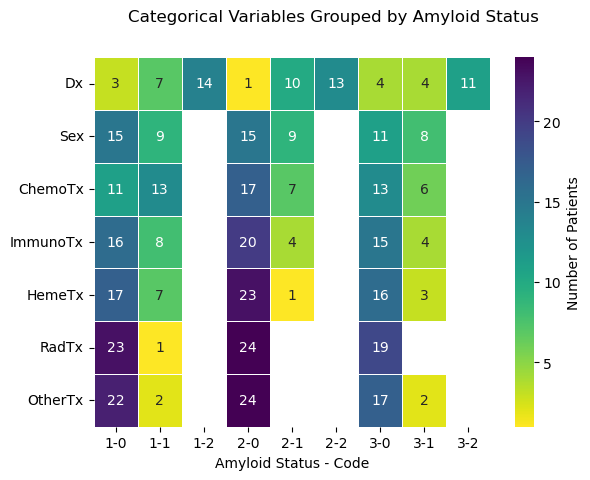

In [26]:
groupname = "Amyloid Status"
dict_category_counts = {}
df_input = df_summary_DxAdj_data
list_categories = ["Dx", "Sex", "ChemoTx", "ImmunoTx", "HemeTx", "RadTx", "OtherTx"]
for category in list_categories: 
    category_counts = df_input.groupby(groupname)[category].value_counts()
    dict_category_counts[category] = category_counts

df_category_counts_forplot = pd.DataFrame.from_dict(dict_category_counts, orient = 'index')

fig, ax = plt.subplots()
ax = sns.heatmap(df_category_counts_forplot.reindex(sorted(df_category_counts_forplot.columns),axis =1), annot=True, linewidths= 0.5, cmap = 'viridis_r', cbar_kws={"label":"Number of Patients"})
ax.set_xlabel("Amyloid Status - Code")
fig.suptitle("Categorical Variables Grouped by Amyloid Status")

fig_file_out = ptFn.outputFiguresPath(fileName_header=fileNameHeader_all, fileName_mid="heatmap_byAL_", 
                                 fileName_suff= fileNameSuffix, parent_dir=outputDir, folderName=folder_data_out)

fig.savefig(fig_file_out, bbox_inches = "tight")

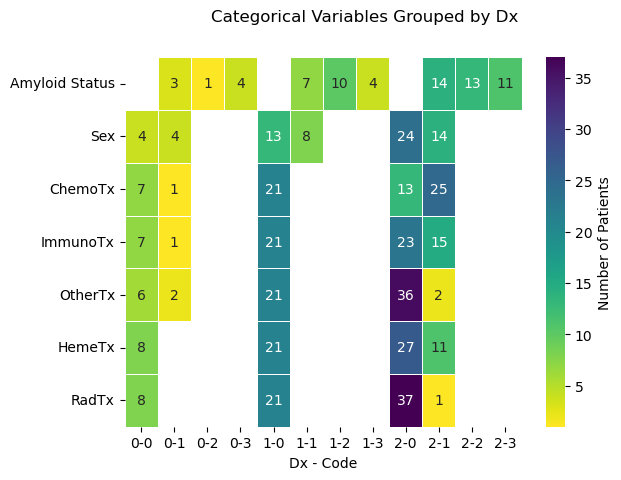

In [27]:
groupname = "Dx"
dict_category_counts = {}
df_input = df_summary_DxAdj_data
list_categories = ["Amyloid Status", "Sex", "ChemoTx", "ImmunoTx", "HemeTx", "RadTx", "OtherTx"]
for category in list_categories: 
    category_counts = df_input.groupby(groupname)[category].value_counts()
    dict_category_counts[category] = category_counts

df_category_counts_forplot = pd.DataFrame.from_dict(dict_category_counts, orient = 'index')

fig, ax = plt.subplots()
ax = sns.heatmap(df_category_counts_forplot.reindex(sorted(df_category_counts_forplot.columns),axis =1), annot=True, linewidths= 0.5, cmap = 'viridis_r', cbar_kws={"label":"Number of Patients"})
ax.set_xlabel("Dx - Code")
fig.suptitle("Categorical Variables Grouped by Dx")

fig_file_out = ptFn.outputFiguresPath(fileName_header=fileNameHeader_all, fileName_mid="heatmap_byDx_", 
                                 fileName_suff= fileNameSuffix, parent_dir=outputDir, folderName=folder_data_out)

fig.savefig(fig_file_out, bbox_inches = "tight")

In [28]:
print(path)

C:/Users/maega\UFL Dropbox/Maegan Cremer/research-share/Maegan/Projects\Cardiac-Amyloidosis-Multiple-Myeloma\014_Mistic2


In [29]:
# boxplot = df_AL_Known_DxAdj.boxplot(by = "Amyloid Status", column= ["Sex", "Dx", 
#                          "ChemoTx", "ImmunoTx", "HemeTx", "RadTx", "OtherTx","ChemoTx Number", "ImmunoTx Number", 
#                          "HemeTx Number", "RadTx Number", "OtherTx Number"] ,
#                          fontsize = 8, figsize = (10, 10))


In [30]:
# boxplot = df_summary_EchoAdj_data.boxplot(by = "Amyloid Status", column= ["Sex", "Dx", 
#                          "ChemoTx", "ImmunoTx", "HemeTx", "RadTx", "OtherTx","ChemoTx Number", "ImmunoTx Number", 
#                          "HemeTx Number", "RadTx Number", "OtherTx Number"] ,
#                          fontsize = 8, figsize = (10, 10))

### plotting lab values for near echo

In [31]:
columnsForFigure = list(df_summary_EchoAdj_data.columns)
number_of_figs_in_plot = 9 
#slice the list of columns in groups of 9 

slices_sorted = [columnsForFigure[i:i + number_of_figs_in_plot] for i in range(0, len(columnsForFigure), number_of_figs_in_plot)] 

In [32]:
# i =0
# for slice in slices_sorted: 
#     fig, ax = plt.subplots(figsize = (10,10))
#     boxplot = df_summary_EchoAdj_data.boxplot(by = "Amyloid Status", column= slice,
#                          fontsize = 8, figsize = (10, 10), sharey = False, ax = ax)
    
#     fig_file_out = outputFiguresPath(fileName_header=fileNameHeader_all, fileName_mid="_boxEchoAdj_" + str(i) + "_", 
#                                  fileName_suff= fileNameSuffix, parent_dir=outputDir, folderName=folder_data_out)
#     fig.savefig(fig_file_out, bbox_inches = "tight")
#     i = i+1

In [33]:
# i =0
# for slice in slices_sorted: 
#     fig, ax = plt.subplots(figsize = (10, 10))
#     boxplot = df_summary_DxAdj_data.boxplot(by = "Amyloid Status", column= slice,
#                          fontsize = 8, figsize = (10, 10), sharey = False, ax = ax)
    
#     fig_file_out = outputFiguresPath(fileName_header=fileNameHeader_all, fileName_mid="_boxbyVal_DxAdj_" + str(i) + "_", 
#                                  fileName_suff= fileNameSuffix, parent_dir=outputDir, folderName=folder_data_out)
#     fig.savefig(fig_file_out, bbox_inches = "tight")
#     i = i+1

In [34]:
# i =0
# for slice in slices_sorted: 
#     fig, ax = plt.subplots(figsize = (15, 8))
#     boxprops_dict = {"color" : 'blue', "alpha": 0.5}
#     boxplot = df_ALPos_DxAdj.boxplot(column = slice, fontsize = 8, figsize = (15, 8), rot = 90, ax = ax, color = {"boxes" : "blue"} )
#     boxplot2 = df_ALNeg_DxAdj.boxplot(column = slice, fontsize = 8, figsize = (15, 8), rot = 90, ax = ax,color = {"boxes" : "red"})
#     i = i+1
#     # fig_file_out = outputFiguresPath(fileName_header=fileNameHeader_all, fileName_mid="_boxDxAdj_" + str(i) + "_", 
#     #                              fileName_suff= fileNameSuffix, parent_dir=outputDir, folderName=folder_data_out)
#     # fig.savefig(fig_file_out)

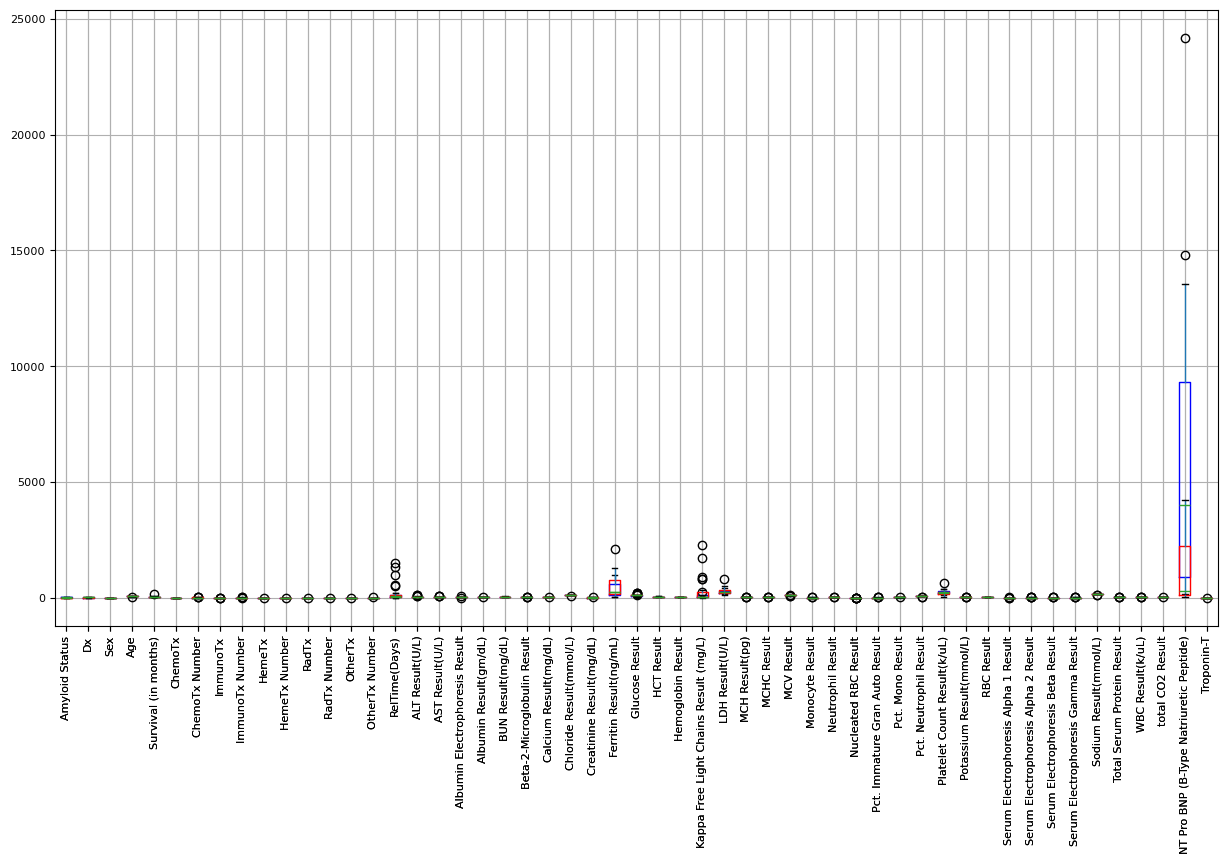

In [35]:
fig, ax = plt.subplots(figsize = (15, 8))
boxprops_dict = {"color" : 'blue', "alpha": 0.5}
boxplot = df_ALPos_DxAdj.boxplot(fontsize = 8, figsize = (15, 8), rot = 90, ax = ax, color = {"boxes" : "blue"} )
boxplot2 = df_ALNeg_DxAdj.boxplot(fontsize = 8, figsize = (15, 8), rot = 90, ax = ax,color = {"boxes" : "red"})

In [36]:
# # by amyloid status
# #vertical box plot
# dataToPlot_positive = df_ALPos_DxAdj
# dataToPlot_negative = df_ALNeg_DxAdj

# # boxToPlot_allPts = [dataToPlot_positive,dataToPlot_negative]

# sorted_columnNames = list(df_ALPos_DxAdj.columns)

# fig, ax = plt.subplots(figsize = (15,8))

# # boxplot = ax.boxplot(boxToPlot_allPts, patch_artist = True)
# ax.boxplot(dataToPlot_positive, patch_artist = True, boxprops={"facecolor" : 'blue', "alpha": 0.5},
#                      flierprops = {"marker" : '.', "markersize" : 6, "markerfacecolor" :'blue', "alpha": 0.5})

# # boxplot = ax.boxplot(dataToPlot_negative, patch_artist = True, boxprops={"facecolor" : 'red', "alpha": 0.5},
# #                      flierprops = {"marker" : '.', "markersize" : 6, "markerfacecolor" :'red', "alpha": 0.5})

# # ax.set_xticklabels(sorted_columnNames, rotation = 'vertical', fontsize = 8 )
# ax.set_xticks(np.arange(0,len(sorted_columnNames), step =1), sorted_columnNames, rotation = 'vertical', fontsize = 8 )

# ax.set_title("Lab values adjacent to diagnostic imaging grouped by Amyloid Status")
# # ax.yaxis.set_inverted(True)

# # plt.tight_layout()

# # figPathBar = outputFiguresPath(fileName_header=fileNameHeader, fileName_mid="-boxALStat_vert_" , 
# #                             fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)

# # plt.savefig(figPathBar, bbox_inches = 'tight')

## statistics based on amyloid status

<Axes: >

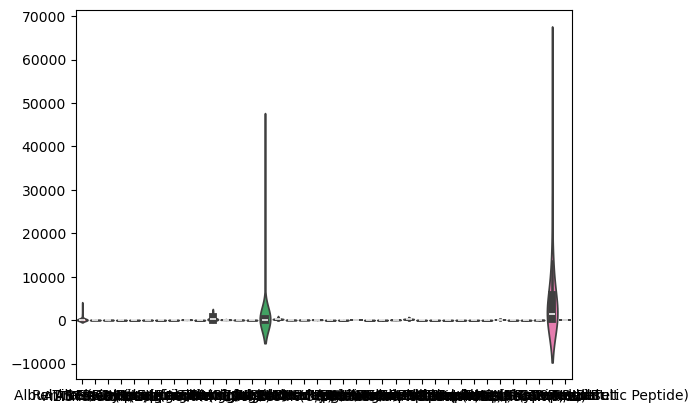

In [37]:
#testing violin plots 

sns.violinplot(data = df_labs_DxAdj)